In [1]:
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
from xml.dom.minidom import parse

# Preview

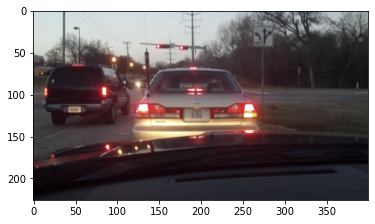

In [3]:
image = cv2.imread("./database/train/images/Cars70.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

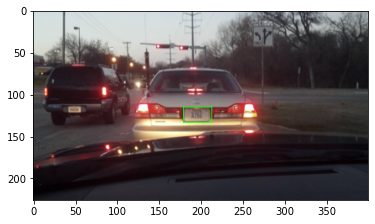

In [4]:
plt.imshow(cv2.rectangle(image,(179,115),(213,133),(0,255,0),1))

# Convert kaggle dataset to YOLO format

In [16]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

def save_file(img_jpg_file_name, size, img_box):
    classes = ['license']
    # save_file_name = DATA_ROOT + DEST_LABELS_PATH + '/' + img_jpg_file_name + '.txt'
    save_file_name = './database/validation/labels/' + img_jpg_file_name + '.txt'
    # print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:                  
        #cls_num = classes.index(box[0]) # find class_id
        cls_num = 0
        new_box = cord_converter(size, box[1:]) # convert box coord into YOLO x,y,w,h

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()
    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    # print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        # print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [15]:
ANNOTATIONS_PATH = "./database/validation/annotations"

files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

# YOLO Training
This line probably needs to be executed in terminal

In [21]:
!python ./yolov5/train.py --img 416 --batch 16 --epochs 300 --data data/alpr.yaml --cfg models/yolov5s.yaml

# YOLO Detecting
This line probably needs to be executed in terminal

In [5]:
### --source should have the directory of the dataset
### --weights should have the weight of the trained YOLO network
!python ./yolov5/detect.py --source /Data/Downloads/Ch2_002_IMG/center/ --conf 0.35 --weights runs/train/exp/weights/best.pt --save-txt